# Seoul Restaurants Clustering

## Part 3 : Clustering districts

In this part, we will use the data we processed in the second part to cluster districts.

In [88]:
# Import libraries
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium # map rendering library
from folium.plugins import FastMarkerCluster, MarkerCluster
from sklearn.cluster import KMeans # K-Means clustering algorithm
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering # Agglomerative clustering algorithm
import scipy.cluster.hierarchy as shc 
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [89]:
# Load data from the file we saved in the previous part into a data frame
df_venues = pd.read_pickle('restaurants_list_prepared.pkl')

In [90]:
df_venues.head()

Id             Name            Category  \
0  5b83cf2cc0cacb002c0bd030              인기명  Seafood Restaurant   
1  5dc62e31e42b4c000735f531  Nal,See (날,See)      Sandwich Place   
2  5d7e19bed13342000856212d              핵도그       Hot Dog Joint   
3  4ddca1eab0fba481fc8678e4             한우목장          Steakhouse   
4  4eaa7d8d49015844898445d0          풍년 닭도리탕   Korean Restaurant   

          Address   Latitude   Longitude District Neighbourhood Legal  \
0            None  37.538245  126.947835      마포구                 도화동   
1       증산로21길 16  37.596088  126.913109      은평구                 신사동   
2  보문로 99 영광빌딩 1층  37.583890  127.019922      성북구               보문동5가   
3            None  37.606292  127.061433      성북구                 석관동   
4   중구 세종대로11길 30  37.563080  126.977783       중구                 북창동   

  Neighbourhood Admin  
0                 도화동  
1                신사1동  
2                 보문동  
3                 석관동  
4                 소공동

In [91]:
# Let's calculate how many restaurants we retrieved for each district
df_venue_dist_count = df_venues.groupby('District').count()[['Id']].sort_values(by=['Id'], ascending=False).reset_index()
df_venue_dist_count.describe()

Id
count    25.00000
mean    620.04000
std     384.04215
min     128.00000
25%     340.00000
50%     547.00000
75%     915.00000
max    1592.00000

On a total of 25 districts, we retrieved an average of 620 restaurants per districts. The minimum is 128 and the maximum is 1592.

In [92]:
# Let's plot the districts on a map of Seoul

# Create map of Seoul using the central latitude and longitude of the capital
map_seoul = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

# Load our GeoJSON file that we found on internet
geo_path = 'seoul_gu_geojson.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# Add a Choropleth layer based on the number of restaurants retrieved for each district
folium.Choropleth(
    geo_data = geo_str,
    data=df_venue_dist_count,
    columns=['District', 'Id'],
    key_on='feature.properties.name',    
    fill_color = 'YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.5, 
    ).add_to(map_seoul)

map_seoul

Lighter districts contain fewer restaurants.

Prior to clustering our restaurants, we need to convert the 'category' field into a numerical field. Converting a categorical feature to a numerical feature can be done using dummy variables (0 or 1) via a process called one-hot encoding

In [93]:
# Make a data frame with a one-hot encoding of categories (one column for each category)
df_venues_onehot = pd.get_dummies(df_venues[['Category']], prefix="", prefix_sep="")

# Add the neighborhood column back to the data frame
df_venues_onehot['District'] = df_venues['District'] 

# Move the neighborhood column to the first column
fixed_columns = [df_venues_onehot.columns[-1]] + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

In [94]:
df_venues_onehot

District  American Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  \
0          마포구                    0                 0          0           0   
1          은평구                    0                 0          0           0   
2          성북구                    0                 0          0           0   
3          성북구                    0                 0          0           0   
4           중구                    0                 0          0           0   
...        ...                  ...               ...        ...         ...   
15571     영등포구                    0                 0          0           0   
15572      동작구                    0                 0          0           0   
15573      종로구                    0                 0          0           0   
15574      금천구                    0                 0          0           0   
15575      종로구                    0                 0          0           0   

       Bakery  Bar  Beer Bar  Bistro  Bookstore  ...  Tapas Restaurant  \
0           0    0         0       0          0  ...                 0   
1           0    0         0       0          0  ...                 0   
2           0    0         0       0          0  ...                 0   
3           0    0         0       0          0  ...                 0   
4           0    0         0       0          0  ...                 0   
...       ...  ...       ...     ...        ...  ...               ...   
15571       0    0         0       0          0  ...                 0   
15572       0    0         0       0          0  ...                 0   
15573       0    0         0       0          0  ...                 0   
15574       0    0         0       0          0  ...                 0   
15575       0    0         0       0          0  ...                 0   

       Tea Room  Thai Restaurant  Theme Restaurant  Turkish Restaurant  \
0             0                0                 0                   0   
1             0                0                 0                   0   
2             0                0                 0                   0   
3             0                0                 0                   0   
4             0                0                 0                   0   
...         ...              ...               ...                 ...   
15571         0                0                 0                   0   
15572         0                0                 0                   0   
15573         0                0                 0                   0   
15574         0                0                 0                   0   
15575         0                0                 0                   0   

       Udon Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                    0                              0                      0   
1                    0                              0                      0   
2                    0                              0                      0   
3                    0                              0                      0   
4                    0                              0                      0   
...                ...                            ...                    ...   
15571                0                              0                      0   
15572                0                              0                      0   
15573                0                              0                      0   
15574                0                              0                      0   
15575                0                              0                      0   

       Wine Bar  Wings Joint  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0  
...         ...          ...  
15571         0            0  
15572         0            0  
15573         0            

In [95]:
# Now we can group our restaurants by district and see what is the ratio of cuisine type for each district
df_venues_grouped = df_venues_onehot.groupby('District').mean().reset_index()
df_venues_grouped

District  American Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  \
0       강남구             0.002086          0.010428   0.076121    0.001043   
1       강동구             0.003656          0.021938   0.058501    0.000000   
2       강북구             0.000000          0.052980   0.099338    0.000000   
3       강서구             0.002037          0.032587   0.071283    0.000000   
4       관악구             0.000000          0.031250   0.070312    0.000000   
5       광진구             0.002268          0.029478   0.070295    0.002268   
6       구로구             0.004202          0.018908   0.067227    0.002101   
7       금천구             0.000000          0.035533   0.055838    0.000000   
8       노원구             0.003891          0.031128   0.077821    0.000000   
9       도봉구             0.000000          0.011834   0.053254    0.000000   
10     동대문구             0.001684          0.015152   0.055556    0.001684   
11      동작구             0.004474          0.013423   0.060403    0.000000   
12      마포구             0.000000          0.009885   0.072488    0.002471   
13     서대문구             0.001377          0.024793   0.050964    0.001377   
14      서초구             0.004008          0.020040   0.056112    0.000000   
15      성동구             0.002915          0.016035   0.093294    0.002915   
16      성북구             0.001093          0.019672   0.049180    0.000000   
17      송파구             0.001337          0.028075   0.068182    0.000000   
18      양천구             0.000000          0.029762   0.047619    0.000000   
19     영등포구             0.005123          0.017418   0.062500    0.001025   
20      용산구             0.004198          0.016793   0.061293    0.001679   
21      은평구             0.000000          0.032491   0.084838    0.000000   
22      종로구             0.002513          0.018844   0.031407    0.000628   
23       중구             0.000000          0.011594   0.051208    0.000966   
24      중랑구             0.000000          0.038235   0.061765    0.000000   

      Bakery       Bar  Beer Bar    Bistro  Bookstore  ...  Tapas Restaurant  \
0   0.050052  0.000000  0.000000  0.004171   0.000000  ...          0.000000   
1   0.040219  0.000000  0.000000  0.001828   0.000000  ...          0.000000   
2   0.026490  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
3   0.018330  0.002037  0.000000  0.000000   0.000000  ...          0.000000   
4   0.046875  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
5   0.038549  0.000000  0.000000  0.006803   0.002268  ...          0.000000   
6   0.065126  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
7   0.030457  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
8   0.035019  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
9   0.035503  0.000000  0.000000  0.000000   0.000000  ...          0.000000   
10  0.035354  0.000000  0.000000  0.003367   0.000000  ...          0.000000   
11  0.062640  0.000000  0.000000  0.002237   0.000000  ...          0.000000   
12  0.047776  0.000824  0.000000  0.006590   0.000824  ...          0.001647   
13  0.057851  0.000000  0.001377  0.005510   0.000000  ...          0.000000   
14  0.054108  0.000000  0.000000  0.004008   0.000000  ...          0.000000   
15  0.042274  0.001458  0.001458  0.001458   0.000000  ...          0.000000   
16  0.037158  0.000000  0.000000  0.001093   0.000000  ...          0.000000   
17  0.060160  0.000000  0.000000  0.001337   0.000000  ...          0.000000   
18  0.035714  0.000000  0.000000  0.005952   0.000000  ...          0.000000   
19  0.042008  0.000000  0.000000  0.003074   0.000000  ...          0.000000   
20  0.045340  0.000000  0.000000  0.009236   0.000000  ...          0.001679   
21  0.041516  0.000000  0.000000  0.005415   0.000000  ...          0.000000   
22  0.028894  0.000628  0.000000  0.001884   0.002513  ...          0.001256   
23  0.051208  0.000966  0.001932  0.015459   0.000000  ...          0.000000   


In [96]:
# Let's see what are the most common restaurants in each district

# We first define a function that returns the x most common categories in a row
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# We will filter to the top 8 categories
num_top_venues = 8
indicators = ['st', 'nd', 'rd']

# Create columns to our data frame
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common'.format(ind+1))

# Populate the data frame
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['District'] = df_venues_grouped['District']

for ind in np.arange(df_venues_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_venues_grouped.iloc[ind, :], num_top_venues)

df_venues_sorted

District    1st most common 2nd most common      3rd most common  \
0       강남구  Korean Restaurant     Coffee Shop                 Café   
1       강동구  Korean Restaurant            Café            BBQ Joint   
2       강북구  Korean Restaurant       BBQ Joint          Coffee Shop   
3       강서구  Korean Restaurant            Café            BBQ Joint   
4       관악구  Korean Restaurant            Café  Fried Chicken Joint   
5       광진구  Korean Restaurant            Café          Coffee Shop   
6       구로구  Korean Restaurant     Coffee Shop                 Café   
7       금천구  Korean Restaurant     Coffee Shop                 Café   
8       노원구  Korean Restaurant            Café            BBQ Joint   
9       도봉구  Korean Restaurant            Café  Fried Chicken Joint   
10     동대문구  Korean Restaurant            Café          Coffee Shop   
11      동작구  Korean Restaurant            Café          Coffee Shop   
12      마포구  Korean Restaurant            Café          Coffee Shop   
13     서대문구  Korean Restaurant            Café          Coffee Shop   
14      서초구  Korean Restaurant            Café          Coffee Shop   
15      성동구  Korean Restaurant     Coffee Shop                 Café   
16      성북구  Korean Restaurant            Café          Coffee Shop   
17      송파구  Korean Restaurant            Café          Coffee Shop   
18      양천구  Korean Restaurant            Café          Coffee Shop   
19     영등포구  Korean Restaurant            Café          Coffee Shop   
20      용산구  Korean Restaurant            Café          Coffee Shop   
21      은평구  Korean Restaurant            Café            BBQ Joint   
22      종로구  Korean Restaurant            Café          Coffee Shop   
23       중구  Korean Restaurant     Coffee Shop                 Café   
24      중랑구  Korean Restaurant     Coffee Shop            BBQ Joint   

        4th most common      5th most common       6th most common  \
0             BBQ Joint  Japanese Restaurant                Bakery   
1   Fried Chicken Joint          Coffee Shop            Restaurant   
2                  Café           Restaurant      Asian Restaurant   
3           Coffee Shop   Chinese Restaurant    Seafood Restaurant   
4             BBQ Joint  Japanese Restaurant           Snack Place   
5             BBQ Joint               Bakery            Restaurant   
6             BBQ Joint               Bakery            Restaurant   
7             BBQ Joint   Chinese Restaurant  Fast Food Restaurant   
8           Coffee Shop           Restaurant    Chinese Restaurant   
9             BBQ Joint   Chinese Restaurant    Seafood Restaurant   
10            BBQ Joint  Japanese Restaurant    Chinese Restaurant   
11               Bakery            BBQ Joint   Fried Chicken Joint   
12            BBQ Joint               Bakery    Chinese Restaurant   
13               Bakery            BBQ Joint   Japanese Restaurant   
14            BBQ Joint               Bakery    Chinese Restaurant   
15            BBQ Joint               Bakery   Fried Chicken Joint   
16            BBQ Joint  Japanese Restaurant            Restaurant   
17            BBQ Joint               Bakery            Restaurant   
18            BBQ Joint  Fried Chicken Joint                Bakery   
19            BBQ Joint   Chinese Restaurant                Bakery   
20            BBQ Joint               Bakery   Japanese Restaurant   
21          Coffee Shop           Restaurant                Bakery   
22   Italian Restaurant   Chinese Restaurant   Japanese Restaurant   
23            BBQ Joint   Chinese Restaurant                Bakery   
24         Noodle House  Fried Chicken Joint                  Café   

         7th most common      8th most common  
0     Chinese Restaurant   Italian Restaurant  
1                 Bakery         Noodle House  
2     Chinese Restaurant  Fried Chicken Joint  
3           Noodle House           Restaurant  
4                 Bakery           Restaurant  
5     Seafood Restaurant  Japanese Restaurant  

Now we can try find clusters of neighbourhoods (neighbourhoods which are similar in the type of restaurants they host)

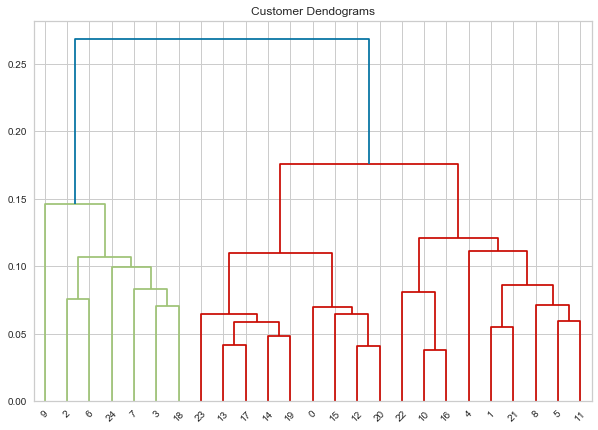

In [97]:
# 1. Hierarchical clustering

# We use a Hierarchical Clustering algorithm from scikit-learn, called AgglomerativeClustering
df_venues_clustering = df_venues_grouped.drop('District', 1) 
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(df_venues_clustering, method='ward'))

In [98]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_venues_clustering)
print(cluster.labels_)
#df_venues_sorted.drop(['Cluster'], axis=1, inplace = True)
df_venues_sorted.insert(0, 'Cluster', cluster.labels_)
df_venues_sorted

[2 1 0 0 1 1 0 0 1 0 1 1 2 2 2 2 1 2 0 2 2 1 1 2 0]


Cluster District    1st most common 2nd most common      3rd most common  \
0         2      강남구  Korean Restaurant     Coffee Shop                 Café   
1         1      강동구  Korean Restaurant            Café            BBQ Joint   
2         0      강북구  Korean Restaurant       BBQ Joint          Coffee Shop   
3         0      강서구  Korean Restaurant            Café            BBQ Joint   
4         1      관악구  Korean Restaurant            Café  Fried Chicken Joint   
5         1      광진구  Korean Restaurant            Café          Coffee Shop   
6         0      구로구  Korean Restaurant     Coffee Shop                 Café   
7         0      금천구  Korean Restaurant     Coffee Shop                 Café   
8         1      노원구  Korean Restaurant            Café            BBQ Joint   
9         0      도봉구  Korean Restaurant            Café  Fried Chicken Joint   
10        1     동대문구  Korean Restaurant            Café          Coffee Shop   
11        1      동작구  Korean Restaurant            Café          Coffee Shop   
12        2      마포구  Korean Restaurant            Café          Coffee Shop   
13        2     서대문구  Korean Restaurant            Café          Coffee Shop   
14        2      서초구  Korean Restaurant            Café          Coffee Shop   
15        2      성동구  Korean Restaurant     Coffee Shop                 Café   
16        1      성북구  Korean Restaurant            Café          Coffee Shop   
17        2      송파구  Korean Restaurant            Café          Coffee Shop   
18        0      양천구  Korean Restaurant            Café          Coffee Shop   
19        2     영등포구  Korean Restaurant            Café          Coffee Shop   
20        2      용산구  Korean Restaurant            Café          Coffee Shop   
21        1      은평구  Korean Restaurant            Café            BBQ Joint   
22        1      종로구  Korean Restaurant            Café          Coffee Shop   
23        2       중구  Korean Restaurant     Coffee Shop                 Café   
24        0      중랑구  Korean Restaurant     Coffee Shop            BBQ Joint   

        4th most common      5th most common       6th most common  \
0             BBQ Joint  Japanese Restaurant                Bakery   
1   Fried Chicken Joint          Coffee Shop            Restaurant   
2                  Café           Restaurant      Asian Restaurant   
3           Coffee Shop   Chinese Restaurant    Seafood Restaurant   
4             BBQ Joint  Japanese Restaurant           Snack Place   
5             BBQ Joint               Bakery            Restaurant   
6             BBQ Joint               Bakery            Restaurant   
7             BBQ Joint   Chinese Restaurant  Fast Food Restaurant   
8           Coffee Shop           Restaurant    Chinese Restaurant   
9             BBQ Joint   Chinese Restaurant    Seafood Restaurant   
10            BBQ Joint  Japanese Restaurant    Chinese Restaurant   
11               Bakery            BBQ Joint   Fried Chicken Joint   
12            BBQ Joint               Bakery    Chinese Restaurant   
13               Bakery            BBQ Joint   Japanese Restaurant   
14            BBQ Joint               Bakery    Chinese Restaurant   
15            BBQ Joint               Bakery   Fried Chicken Joint   
16            BBQ Joint  Japanese Restaurant            Restaurant   
17            BBQ Joint               Bakery            Restaurant   
18            BBQ Joint  Fried Chicken Joint                Bakery   
19            BBQ Joint   Chinese Restaurant                Bakery   
20            BBQ Joint               Bakery   Japanese Restaurant   
21          Coffee Shop           Restaurant                Bakery   
22   Italian Restaurant   Chinese Restaurant   Japanese Restaurant   
23            BBQ Joint   Chinese Restaurant                Bakery   
24         Noodle House  Fried Chicken Joint                  Café   

         7th most common      8th most common  
0     Chinese Restaurant   Italian Restaurant  
1     

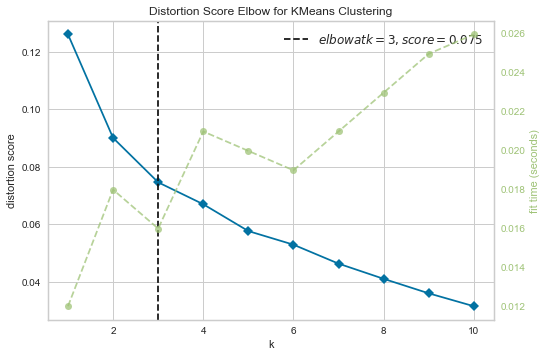

In [105]:
# 2. K-means Clustering 

# We use a K-means Clustering algorithm from scikit-learn
# And an 'elbow' finding method from yellowbrick to find the optimal number of clusters
df_venues_clustering = df_venues_grouped.drop('District', 1) 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))

visualizer.fit(df_venues_clustering) # Fit the data to the visualizer
visualizer.show()  

In [56]:
# Based on the graph, the optimal value of k is :
opt_k = 3

# Fit the model using the optimal value of k
model = KMeans(n_clusters=opt_k)
model.fit(df_venues_clustering)
labels = model.labels_

# Add the clustering labels to our data frame
df_venues_sorted.drop(['Cluster'], axis=1, inplace = True)
df_venues_sorted.insert(0, 'Cluster', labels)
df_venues_sorted

Cluster District    1st most common    2nd most common  \
0         2      강남구               Café  Korean Restaurant   
1         1      강동구  Korean Restaurant               Café   
2         1      강북구  Korean Restaurant               Café   
3         3      강서구  Korean Restaurant               Café   
4         1      관악구  Korean Restaurant               Café   
5         2      광진구               Café  Korean Restaurant   
6         1      구로구  Korean Restaurant               Café   
7         0      금천구  Korean Restaurant               Café   
8         2      노원구               Café  Korean Restaurant   
9         3      도봉구  Korean Restaurant               Café   
10        0     동대문구               Café  Korean Restaurant   
11        2      동작구               Café  Korean Restaurant   
12        2      마포구               Café  Korean Restaurant   
13        0     서대문구  Korean Restaurant               Café   
14        0      서초구               Café  Korean Restaurant   
15        2      성동구               Café  Korean Restaurant   
16        0      성북구  Korean Restaurant               Café   
17        1      송파구  Korean Restaurant               Café   
18        3      양천구  Korean Restaurant               Café   
19        0     영등포구  Korean Restaurant               Café   
20        2      용산구               Café  Korean Restaurant   
21        1      은평구  Korean Restaurant               Café   
22        0      종로구               Café  Korean Restaurant   
23        0       중구  Korean Restaurant               Café   
24        3      중랑구  Korean Restaurant               Café   

        3rd most common      4th most common       5th most common  \
0             BBQ Joint  Japanese Restaurant                Bakery   
1             BBQ Joint  Fried Chicken Joint            Restaurant   
2             BBQ Joint           Restaurant    Chinese Restaurant   
3             BBQ Joint   Chinese Restaurant    Seafood Restaurant   
4   Fried Chicken Joint            BBQ Joint   Japanese Restaurant   
5             BBQ Joint               Bakery            Restaurant   
6             BBQ Joint               Bakery            Restaurant   
7             BBQ Joint   Chinese Restaurant  Fast Food Restaurant   
8             BBQ Joint           Restaurant    Chinese Restaurant   
9   Fried Chicken Joint            BBQ Joint    Chinese Restaurant   
10            BBQ Joint  Japanese Restaurant    Chinese Restaurant   
11               Bakery            BBQ Joint   Fried Chicken Joint   
12            BBQ Joint               Bakery    Chinese Restaurant   
13               Bakery            BBQ Joint   Japanese Restaurant   
14            BBQ Joint               Bakery    Chinese Restaurant   
15            BBQ Joint               Bakery   Fried Chicken Joint   
16            BBQ Joint  Japanese Restaurant            Restaurant   
17            BBQ Joint               Bakery            Restaurant   
18            BBQ Joint  Fried Chicken Joint                Bakery   
19            BBQ Joint   Chinese Restaurant                Bakery   
20            BBQ Joint               Bakery   Japanese Restaurant   
21            BBQ Joint           Restaurant                Bakery   
22   Italian Restaurant   Chinese Restaurant   Japanese Restaurant   
23   Chinese Restaurant            BBQ Joint                Bakery   
24            BBQ Joint  Fried Chicken Joint          Noodle House   

        6th most common      7th most common      8th most common  
0    Chinese Restaurant   Italian Restaurant  Fried Chicken Joint  
1                Bakery         Noodle House   Chinese Restaurant  
2      Asian Restaurant  Fried Chicken Joint   Seafood Restaurant  
3          Noodle House           Restaurant     Asian Restaurant  
4           Snack Place               Bakery           Restaurant  
5   Japanese Restaurant   Seafood Restaurant   Chinese Restaurant  
6   Fried Chicken Joint   Chinese Restaurant   Seafood Restaurant  
7      Asian Restaurant   

In [99]:
# Create map of Seoul using the central latitude and longitude of the capital
map_seoul = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

# Load our GeoJSON file that we found on internet
geo_path = 'seoul_gu_geojson.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# Add a Choropleth layer based on the number of restaurants retrieved for each neighbourhood
folium.Choropleth(
    geo_data = geo_str,
    data=df_venues_sorted,
    columns=['District', 'Cluster'],
    key_on='feature.properties.name',    
    fill_color = 'Dark2',
    fill_opacity=0.5, 
    line_opacity=0.6, 
    ).add_to(map_seoul)

map_seoul

In [100]:
# Let's examine each cluster to determine the discriminating venue categories that distinguish each cluster.
# Cluster 0
print(df_venues_sorted.loc[df_venues_sorted['Cluster'] == 0, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]].shape)
df_venues_sorted.loc[df_venues_sorted['Cluster'] == 0, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]]

(7, 11)


District  Cluster District    1st most common 2nd most common  \
2       강북구        0      강북구  Korean Restaurant       BBQ Joint   
3       강서구        0      강서구  Korean Restaurant            Café   
6       구로구        0      구로구  Korean Restaurant     Coffee Shop   
7       금천구        0      금천구  Korean Restaurant     Coffee Shop   
9       도봉구        0      도봉구  Korean Restaurant            Café   
18      양천구        0      양천구  Korean Restaurant            Café   
24      중랑구        0      중랑구  Korean Restaurant     Coffee Shop   

        3rd most common 4th most common      5th most common  \
2           Coffee Shop            Café           Restaurant   
3             BBQ Joint     Coffee Shop   Chinese Restaurant   
6                  Café       BBQ Joint               Bakery   
7                  Café       BBQ Joint   Chinese Restaurant   
9   Fried Chicken Joint       BBQ Joint   Chinese Restaurant   
18          Coffee Shop       BBQ Joint  Fried Chicken Joint   
24            BBQ Joint    Noodle House  Fried Chicken Joint   

         6th most common       7th most common      8th most common  
2       Asian Restaurant    Chinese Restaurant  Fried Chicken Joint  
3     Seafood Restaurant          Noodle House           Restaurant  
6             Restaurant   Fried Chicken Joint   Chinese Restaurant  
7   Fast Food Restaurant      Asian Restaurant           Restaurant  
9     Seafood Restaurant                Bakery           Restaurant  
18                Bakery  Fast Food Restaurant     Asian Restaurant  
24                  Café            Restaurant   Seafood Restaurant

In [101]:
# Cluster 1
print(df_venues_sorted.loc[df_venues_sorted['Cluster'] == 1, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]].shape)
df_venues_sorted.loc[df_venues_sorted['Cluster'] == 1, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]]

(9, 11)


District  Cluster District    1st most common 2nd most common  \
1       강동구        1      강동구  Korean Restaurant            Café   
4       관악구        1      관악구  Korean Restaurant            Café   
5       광진구        1      광진구  Korean Restaurant            Café   
8       노원구        1      노원구  Korean Restaurant            Café   
10     동대문구        1     동대문구  Korean Restaurant            Café   
11      동작구        1      동작구  Korean Restaurant            Café   
16      성북구        1      성북구  Korean Restaurant            Café   
21      은평구        1      은평구  Korean Restaurant            Café   
22      종로구        1      종로구  Korean Restaurant            Café   

        3rd most common      4th most common      5th most common  \
1             BBQ Joint  Fried Chicken Joint          Coffee Shop   
4   Fried Chicken Joint            BBQ Joint  Japanese Restaurant   
5           Coffee Shop            BBQ Joint               Bakery   
8             BBQ Joint          Coffee Shop           Restaurant   
10          Coffee Shop            BBQ Joint  Japanese Restaurant   
11          Coffee Shop               Bakery            BBQ Joint   
16          Coffee Shop            BBQ Joint  Japanese Restaurant   
21            BBQ Joint          Coffee Shop           Restaurant   
22          Coffee Shop   Italian Restaurant   Chinese Restaurant   

        6th most common     7th most common      8th most common  
1            Restaurant              Bakery         Noodle House  
4           Snack Place              Bakery           Restaurant  
5            Restaurant  Seafood Restaurant  Japanese Restaurant  
8    Chinese Restaurant        Noodle House  Fried Chicken Joint  
10   Chinese Restaurant              Bakery           Restaurant  
11  Fried Chicken Joint          Restaurant   Chinese Restaurant  
16           Restaurant              Bakery  Fried Chicken Joint  
21               Bakery  Chinese Restaurant  Japanese Restaurant  
22  Japanese Restaurant           BBQ Joint               Bakery

In [102]:
# Cluster 2
print(df_venues_sorted.loc[df_venues_sorted['Cluster'] == 2, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]].shape)
df_venues_sorted.loc[df_venues_sorted['Cluster'] == 2, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]]

(9, 11)


District  Cluster District    1st most common 2nd most common  \
0       강남구        2      강남구  Korean Restaurant     Coffee Shop   
12      마포구        2      마포구  Korean Restaurant            Café   
13     서대문구        2     서대문구  Korean Restaurant            Café   
14      서초구        2      서초구  Korean Restaurant            Café   
15      성동구        2      성동구  Korean Restaurant     Coffee Shop   
17      송파구        2      송파구  Korean Restaurant            Café   
19     영등포구        2     영등포구  Korean Restaurant            Café   
20      용산구        2      용산구  Korean Restaurant            Café   
23       중구        2       중구  Korean Restaurant     Coffee Shop   

   3rd most common 4th most common      5th most common      6th most common  \
0             Café       BBQ Joint  Japanese Restaurant               Bakery   
12     Coffee Shop       BBQ Joint               Bakery   Chinese Restaurant   
13     Coffee Shop          Bakery            BBQ Joint  Japanese Restaurant   
14     Coffee Shop       BBQ Joint               Bakery   Chinese Restaurant   
15            Café       BBQ Joint               Bakery  Fried Chicken Joint   
17     Coffee Shop       BBQ Joint               Bakery           Restaurant   
19     Coffee Shop       BBQ Joint   Chinese Restaurant               Bakery   
20     Coffee Shop       BBQ Joint               Bakery  Japanese Restaurant   
23            Café       BBQ Joint   Chinese Restaurant               Bakery   

        7th most common      8th most common  
0    Chinese Restaurant   Italian Restaurant  
12  Japanese Restaurant   Seafood Restaurant  
13   Chinese Restaurant  Fried Chicken Joint  
14  Japanese Restaurant           Restaurant  
15           Restaurant  Japanese Restaurant  
17  Fried Chicken Joint   Chinese Restaurant  
19  Fried Chicken Joint  Japanese Restaurant  
20   Chinese Restaurant         Noodle House  
23         Noodle House  Japanese Restaurant

In [103]:
# Cluster 2
print(df_venues_sorted.loc[df_venues_sorted['Cluster'] == 3, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]].shape)
df_venues_sorted.loc[df_venues_sorted['Cluster'] == 3, df_venues_sorted.columns[[1] + list(range(0, df_venues_sorted.shape[1]))]]

(0, 11)


Empty DataFrame
Columns: [District, Cluster, District, 1st most common, 2nd most common, 3rd most common, 4th most common, 5th most common, 6th most common, 7th most common, 8th most common]
Index: []

In [104]:
df_venues_grouped[df_venues_grouped['District'] == '도봉구'].iloc[0,1:].sort_values(ascending=False).head(10)

Korean Restaurant       0.307692
Café                    0.147929
Fried Chicken Joint    0.0828402
BBQ Joint              0.0532544
Chinese Restaurant     0.0473373
Seafood Restaurant     0.0414201
Bakery                  0.035503
Restaurant              0.035503
Coffee Shop            0.0295858
Snack Place            0.0295858
Name: 9, dtype: object

Let's try plotting the data differently, with a marker on the center of each district instead of coloring the whole district.
It will allow us to color each district with another data : the average income in that district

In [26]:
# Load data on district center coordinates

# Function to remove any space within a string
def strip_spaces(a_str_with_spaces):
    return a_str_with_spaces.replace(' ', '')

# Read data from file 'seoul_gu_coordinates.csv' and remove any space in the name of the neighbourhood
df_dist_coord = pd.read_csv('seoul_gu_coordinates.csv', index_col=0, converters={'읍면동명 영문': strip_spaces})

# Let's rename some columns written in Korean and drop useless columns
df_dist_coord.rename(columns={"시군구명_한글": "District", "위도": "Latitude", "경도" : "Longitude"}, inplace = True)
df_dist_coord.reset_index(level=['순번'], inplace=True)
df_dist_coord.drop(columns=['순번', '시군구코드', '시군구명_영문', 'ESRI_PK'], inplace = True)

df_dist_coord

District   Latitude   Longitude  Income
0       도봉구  37.665861  127.031767    4500
1       은평구  37.617612  126.922700    4300
2      동대문구  37.583801  127.050700    3700
3       동작구  37.496504  126.944307    4350
4       금천구  37.460097  126.900155    3900
5       구로구  37.495486  126.858121    4250
6       종로구  37.599100  126.986149    4350
7       강북구  37.646995  127.014716    3800
8       중랑구  37.595379  127.093967    4350
9       강남구  37.495985  127.066409    5000
10      강서구  37.565762  126.822656    4600
11       중구  37.557945  126.994190    3450
12      강동구  37.549208  127.146482    4900
13      광진구  37.548144  127.085753    3500
14      마포구  37.562291  126.908780    4250
15      서초구  37.476953  127.037810    5100
16      성북구  37.606991  127.023218    3900
17      노원구  37.655264  127.077120    4050
18      송파구  37.504853  127.114482    4750
19     서대문구  37.582037  126.935667    4500
20      양천구  37.527062  126.856153    3700
21     영등포구  37.520641  126.913924    4300
22      관악구  37.465399  126.943807    3850
23      성동구  37.550675  127.040962    3950
24      용산구  37.531101  126.981074    3850

In [27]:
# Create a data frame which includes both coordinates and the cluster information
df_venues_merged = df_dist_coord
df_venues_merged = df_venues_merged.merge(df_venues_sorted, on='District', how='inner')

df_venues_merged

District   Latitude   Longitude  Income  Cluster    1st most common  \
0       도봉구  37.665861  127.031767    4500        2  Korean Restaurant   
1       은평구  37.617612  126.922700    4300        1  Korean Restaurant   
2      동대문구  37.583801  127.050700    3700        1  Korean Restaurant   
3       동작구  37.496504  126.944307    4350        1  Korean Restaurant   
4       금천구  37.460097  126.900155    3900        2  Korean Restaurant   
5       구로구  37.495486  126.858121    4250        2  Korean Restaurant   
6       종로구  37.599100  126.986149    4350        1  Korean Restaurant   
7       강북구  37.646995  127.014716    3800        2  Korean Restaurant   
8       중랑구  37.595379  127.093967    4350        2  Korean Restaurant   
9       강남구  37.495985  127.066409    5000        0  Korean Restaurant   
10      강서구  37.565762  126.822656    4600        2  Korean Restaurant   
11       중구  37.557945  126.994190    3450        0  Korean Restaurant   
12      강동구  37.549208  127.146482    4900        1  Korean Restaurant   
13      광진구  37.548144  127.085753    3500        1  Korean Restaurant   
14      마포구  37.562291  126.908780    4250        0  Korean Restaurant   
15      서초구  37.476953  127.037810    5100        1  Korean Restaurant   
16      성북구  37.606991  127.023218    3900        1  Korean Restaurant   
17      노원구  37.655264  127.077120    4050        1  Korean Restaurant   
18      송파구  37.504853  127.114482    4750        1  Korean Restaurant   
19     서대문구  37.582037  126.935667    4500        0  Korean Restaurant   
20      양천구  37.527062  126.856153    3700        2  Korean Restaurant   
21     영등포구  37.520641  126.913924    4300        2  Korean Restaurant   
22      관악구  37.465399  126.943807    3850        1  Korean Restaurant   
23      성동구  37.550675  127.040962    3950        0  Korean Restaurant   
24      용산구  37.531101  126.981074    3850        0  Korean Restaurant   

   2nd most common      3rd most common      4th most common  \
0             Café  Fried Chicken Joint            BBQ Joint   
1             Café            BBQ Joint          Coffee Shop   
2             Café          Coffee Shop            BBQ Joint   
3             Café          Coffee Shop               Bakery   
4      Coffee Shop                 Café            BBQ Joint   
5      Coffee Shop                 Café            BBQ Joint   
6             Café          Coffee Shop   Italian Restaurant   
7        BBQ Joint          Coffee Shop                 Café   
8      Coffee Shop            BBQ Joint         Noodle House   
9      Coffee Shop                 Café            BBQ Joint   
10            Café            BBQ Joint          Coffee Shop   
11     Coffee Shop                 Café            BBQ Joint   
12            Café            BBQ Joint  Fried Chicken Joint   
13            Café          Coffee Shop            BBQ Joint   
14            Café          Coffee Shop            BBQ Joint   
15            Café          Coffee Shop            BBQ Joint   
16            Café          Coffee Shop            BBQ Joint   
17            Café            BBQ Joint          Coffee Shop   
18            Café          Coffee Shop            BBQ Joint   
19            Café          Coffee Shop               Bakery   
20            Café          Coffee Shop            BBQ Joint   
21            Café          Coffee Shop            BBQ Joint   
22            Café  Fried Chicken Joint            BBQ Joint   
23     Coffee Shop                 Café            BBQ Joint   
24            Café          Coffee Shop            BBQ Joint   

        5th most common       6th most common       7th most common  \
0    Chinese Restaurant    Seafood Restaurant                Bakery   
1            Restaurant                Bakery    Chinese Restaurant   
2   Japanese Restaurant    Chinese Restaurant                Bakery   
3             BBQ Joint   Fried Chicken Joint            Restaurant   
4    Chinese Restaurant  Fast Food Restaurant      Asian R

In [28]:
# Create map of Seoul using the central latitude and longitude of the capital
map_seoul = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

# Add a Choropleth layer based on average income in our data frame and the GeoJSON data

# Load our GeoJSON file that we found on internet
geo_path = 'seoul_gu_geojson.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

folium.Choropleth(
    geo_data = geo_str,
    data=df_venues_merged,
    columns=['District', 'Income'],
    key_on = 'feature.properties.name',    
    fill_color = 'YlOrRd',
    fill_opacity=0.4, 
    line_opacity=0.4, 
    legend_name='Monthly income level (in wons)'   
    ).add_to(map_seoul)

map_seoul

In [29]:
# Set color scheme for the clusters
x = np.arange(opt_k)
ys = [i + x + (i*x)**2 for i in range(opt_k)]
colors_array = cm.BuPu(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_venues_merged['Latitude'], df_venues_merged['Longitude'], df_venues_merged['District'], df_venues_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_seoul)
    
map_seoul

It's difficult to see any correlation between the most common types of restaurants and the average income in each district.
It could be that the type of restaurants is dependent on some other factors, such as the ratio of businesses over households in a particular district.
Districts with lots of offices are more likely to host cafes and BBQ places.